In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**#Importing libraries**

In [ ]:
import pandas as pd
import numpy as np
from shapely.geometry import Point, box
import geopandas as gpd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

**#Data Loading**

In [ ]:
import geopandas as gpd
crs = 'EPSG:32643'

def load_geo(file): return gpd.read_file(file).to_crs(crs)

faults = gpd.read_file('/content/drive/MyDrive/Individual dataset/Individual dataset/merged_dataset.geojson').to_crs(crs)
folds = gpd.read_file('/content/drive/MyDrive/Individual dataset/Individual dataset/fold.geojson').to_crs(crs)
dykes = gpd.read_file('/content/drive/MyDrive/Individual dataset/Individual dataset/dyke.geojson').to_crs(crs)
lineaments = gpd.read_file('/content/drive/MyDrive/Individual dataset/Individual dataset/merged_lineament_1.geojson').to_crs(crs)
oriented_plane = gpd.read_file('/content/drive/MyDrive/Individual dataset/Individual dataset/oriented_structure_plane_gdf.geojson').to_crs(crs)
oriented_line = gpd.read_file('/content/drive/MyDrive/Individual dataset/Individual dataset/oriented_structure_line.geojson').to_crs(crs)
shear_zone = gpd.read_file('/content/drive/MyDrive/Individual dataset/Individual dataset/shear_zone.geojson').to_crs(crs)
minerals = gpd.read_file('/content/drive/MyDrive/Individual dataset/Individual dataset/combined_data.geojson').to_crs(crs)
geochem=gpd.read_file('/content/drive/MyDrive/Individual dataset/Individual dataset/geochemical_clean.geojson').to_crs(crs)


**#Transforming CSV Data into GeoJSON Format**

In [ ]:

elevation_df = pd.read_csv("/content/drive/MyDrive/Individual dataset/Individual dataset/combined_NGPM_gravity.csv")
elevation_df['geometry'] = elevation_df.apply(lambda row: Point(row['X'], row['Y']), axis=1)
elevation = gpd.GeoDataFrame(elevation_df, geometry='geometry', crs="EPSG:4326").to_crs(crs)


gravity_df = pd.read_csv("/content/drive/MyDrive/Individual dataset/Individual dataset/Physical_properties_rock_samples.csv")
gravity_df['geometry'] = gravity_df.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gravity = gpd.GeoDataFrame(gravity_df, geometry='geometry', crs="EPSG:4326").to_crs(crs)



**#Dropping Irrelevant Columns**

In [ ]:
faults.drop(columns=['toposheet_', 'shape_leng'], errors='ignore',inplace=True)
folds.drop(columns=['input_cent', 'toposheet_'], errors='ignore',inplace=True)
dykes.drop(columns=['toposheet_','shape_leng','lithology','formation','stratigrap'], errors='ignore',inplace=True)
minerals.drop(columns=[
    'exploratio', 'project_ti', 'state_name', 'district',
    'geographic', 'exp_dd_lon', 'exp_dd_lat', 'exp_dms_la', 'exp_dms_lo'
], errors='ignore',inplace=True)
geochem.drop(columns=['toposheet_'], errors='ignore',inplace=True)
lineaments.drop(columns=['toposheet_','lineament_form'], errors='ignore',inplace=True)

**#Generating 4 km Grid
Creating a Uniform 4 km x 4 km Spatial Grid to Overlay on the Study Region**

****

In [ ]:
xmin, ymin, xmax, ymax = geochem.total_bounds
grid_size = 4000
cols = list(np.arange(xmin, xmax, grid_size))
rows = list(np.arange(ymin, ymax, grid_size))
polygons = [box(x, y, x + grid_size, y + grid_size) for x in cols for y in rows]
grid = gpd.GeoDataFrame({'geometry': polygons}, crs=crs)


joined = gpd.sjoin(minerals, grid, how='left', predicate='within')
mineral_counts = joined.groupby('index_right').size()
grid['target'] = 0
grid.loc[mineral_counts.index, 'target'] = 1


**## Overlaying Structural Features on Grid
Mapping geological structures such as faults, folds, dykes, and lineaments onto the 4 km spatial grid and extracting relevant attributes like feature count and distance**

In [ ]:
def overlay_distance_and_count(grid, features_gdf, name):
    joined = gpd.sjoin(grid, features_gdf, how='left', predicate='intersects')
    grid[f'{name}_count'] = joined.groupby(joined.index).size().reindex(grid.index, fill_value=0)
    grid[f'{name}_distance'] = grid.geometry.centroid.apply(
        lambda pt: features_gdf.distance(pt).min() if not features_gdf.empty else np.nan
    )

overlay_distance_and_count(grid, folds, 'fold')
overlay_distance_and_count(grid, faults, 'fault')
overlay_distance_and_count(grid, dykes, 'dyke')
overlay_distance_and_count(grid, lineaments, 'lineament')


**#Overlaying Geochemical,Graivty and Elevation data on Grid Mapping**

In [ ]:
# Geochem
chem_cols = [c for c in geochem.columns if c not in ['geometry', 'X', 'Y', 'sampleno']]
join = gpd.sjoin(grid, geochem, how='left', predicate='contains')
grid = grid.join(join.groupby(join.index)[chem_cols].mean())

# Gravity
gravity_cols = ['Density (g/cc)', 'Susceptibility(X 10^(-6) CGS units)']
join = gpd.sjoin(grid, gravity, how='left', predicate='contains')
grid = grid.join(join.groupby(join.index)[gravity_cols].mean())

# Elevation
elev_cols = ['bouguer_an', 'elevation', 'observed_g', 'theoretical_g']
join = gpd.sjoin(grid, elevation, how='left', predicate='contains')
grid = grid.join(join.groupby(join.index)[elev_cols].mean())


**Data Preparation for Modeling**

****

In [ ]:
X = grid.drop(columns=['geometry', 'target'])
y = grid['target']
X.fillna(X.mean(numeric_only=True), inplace=True)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


**Training the LSTM Model and Assessing Accuracy**

In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(1, X_train_lstm.shape[2]), return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Binary classification


model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.summary()

history = model.fit(
   X_train_lstm, y_train,
   validation_data=(X_test_lstm, y_test),
   epochs=50,
   batch_size=64,
   verbose=1
)


loss, accuracy = model.evaluate(X_test_lstm, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")




y_pred_proba = model.predict(X_test_lstm)
y_pred = (y_pred_proba > 0.5).astype(int)


from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))







/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,977 (152.25 KB)

 Trainable params: 38,977 (152.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8426 - loss: 0.6051 - val_accuracy: 0.9052 - val_loss: 0.4508
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8950 - loss: 0.4173 - val_accuracy: 0.9052 - val_loss: 0.3361
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9123 - loss: 0.3081 - val_accuracy: 0.9071 - val_loss: 0.3047
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9049 - loss: 0.3054 - val_accuracy: 0.9052 - val_loss: 0.2935
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9194 - loss: 0.2688 - val_accuracy: 0.9089 - val_loss: 0.2882
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9269 - loss: 0.2405 - val_accuracy: 0.9089 - val_loss: 0.2806
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9229 - loss: 0.2425 - val_accuracy: 0.9108 - val_loss: 0.2798
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9211 - loss: 0.2389 - val_accuracy: 0.9071 - val_loss

**##Confusion Matrix Visualization**

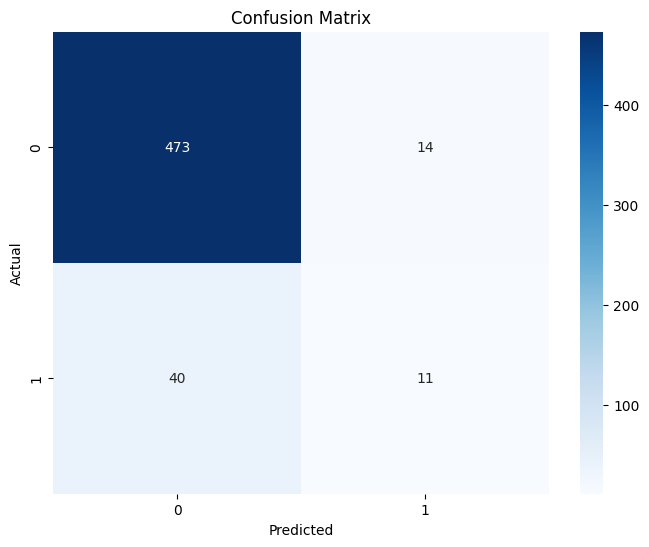

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


**#Predicting Mineral Presence in Unlabeled Data**

In [ ]:
unlabeled_grid = grid[grid['target'] == 0].copy()
X_unlabeled = unlabeled_grid.drop(columns=['geometry', 'target'])
X_unlabeled_scaled = scaler.transform(X_unlabeled)
X_unlabeled_lstm = X_unlabeled_scaled.reshape((X_unlabeled_scaled.shape[0], 1, X_unlabeled_scaled.shape[1]))

pred_probs = model.predict(X_unlabeled_lstm)
pred_probs = pred_probs.flatten()

unlabeled_grid['predicted_target'] = (pred_probs > 0.5).astype(int)
unlabeled_grid['predicted_prob'] = pred_probs

print(unlabeled_grid['predicted_target'].value_counts())


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
predicted_target
0    2429
1       3
Name: count, dtype: int64


In [ ]:
grid.shape

(2688, 81)

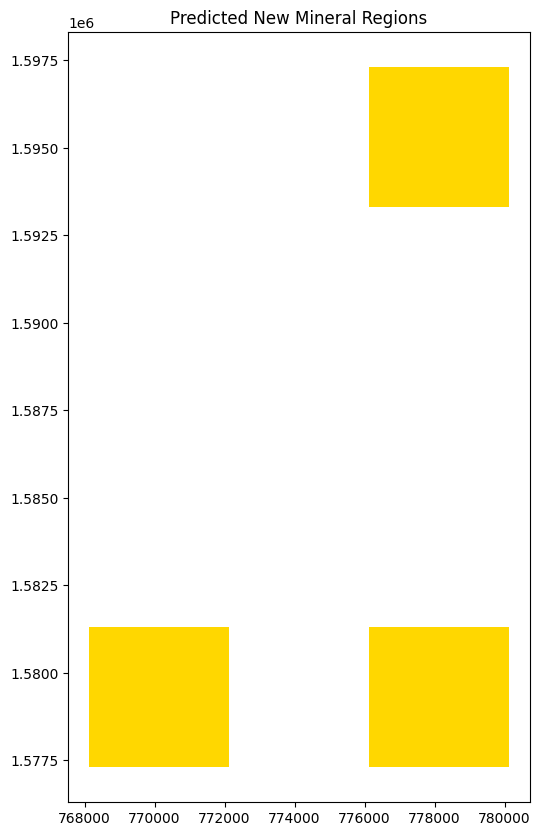

In [ ]:
unlabeled_grid = gpd.GeoDataFrame(unlabeled_grid, geometry='geometry', crs=crs)
unlabeled_grid[unlabeled_grid['predicted_target'] == 1].plot(color='gold', figsize=(10, 10))
plt.title("Predicted New Mineral Regions")
plt.show()


In [ ]:
counts = grid['target'].value_counts()
print(f"Number of 0s (No mineral): {counts.get(0, 0)}")
print(f"Number of 1s (Mineral present): {counts.get(1, 0)}")


Number of 0s (No mineral): 2432
Number of 1s (Mineral present): 256


In [ ]:

if 'predicted_target' in unlabeled_grid.columns:

    new_mineral_zones = unlabeled_grid[unlabeled_grid['predicted_target'] == 1]


    print(new_mineral_zones[['geometry', 'predicted_prob']])
else:
    print("The column 'predicted_target' does not exist in 'unlabeled_grid'. Make sure predictions were made and assigned correctly.")


                                               geometry  predicted_prob
2254  POLYGON ((772131.031 1577306.158, 772131.031 1...        0.998403
2366  POLYGON ((780131.031 1577306.158, 780131.031 1...        0.851731
2370  POLYGON ((780131.031 1593306.158, 780131.031 1...        0.963831


**#Mapping Model New Predictions with Folium**

In [ ]:
import folium

if not new_mineral_zones.empty:

  new_mineral_zones_wgs84 = new_mineral_zones.to_crs("EPSG:4326")


  center_point = new_mineral_zones_wgs84.geometry.unary_union.centroid


  m = folium.Map(location=[center_point.y, center_point.x], zoom_start=8)


  folium.GeoJson(
      new_mineral_zones_wgs84,
      name='Predicted New Mineral Zones',
      tooltip=folium.features.GeoJsonTooltip(fields=['predicted_prob'], aliases=['Predicted Probability: '])
  ).add_to(m)

  folium.LayerControl().add_to(m)


  display(m)
else:
  print("No new mineral zones predicted to plot on the map.")


<ipython-input-20-2288565252>:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  center_point = new_mineral_zones_wgs84.geometry.unary_union.centroid


**#Visualizing Predicted Mineral Zone Centroids on Map
Displaying the centroid points of predicted new mineral zones using Folium for a simplified and interactive geospatial overview**

In [ ]:

if not new_mineral_zones.empty:
    # Convert the predicted mineral zones to WGS84 for Folium
    new_mineral_zones_wgs84 = new_mineral_zones.to_crs("EPSG:4326")

    # Find the centroid of the new mineral zones for map centering
    center_point = new_mineral_zones_wgs84.geometry.unary_union.centroid

    # Create a Folium map centered around the predicted zones
    m = folium.Map(location=[center_point.y, center_point.x], zoom_start=8)

    # Add the *centroids* of the predicted new mineral zones as points to the map
    # Create a GeoDataFrame of centroids from the predicted polygon geometries
    new_mineral_centroids_wgs84 = gpd.GeoDataFrame(
        new_mineral_zones_wgs84.drop(columns='geometry'),
        geometry=new_mineral_zones_wgs84.geometry.centroid,
        crs="EPSG:4326"
    )


    # Add the centroids as points to the map
    folium.GeoJson(
        new_mineral_centroids_wgs84,
        name='Predicted New Mineral Zones (Points)',
        tooltip=folium.features.GeoJsonTooltip(fields=['predicted_prob'], aliases=['Predicted Probability: '])
    ).add_to(m)

    # Add layer control to toggle layers
    folium.LayerControl().add_to(m)

    # Display the map
    display(m) # Use display for showing the map in Colab/Jupyter
else:
    print("No new mineral zones predicted to plot on the map.")


<ipython-input-21-1825854069>:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  center_point = new_mineral_zones_wgs84.geometry.unary_union.centroid
<ipython-input-21-1825854069>:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=new_mineral_zones_wgs84.geometry.centroid,
